# A deeper dive into `AutoEmulate`

## Why `AutoEmulate`

Simulations of real-world physical, chemical or biological processes can be complex and computationally expensive, and will often need high-performance computing resources and a lot of time to run. This becomes a problem when simulations need to be run thousands or tens of thousands of times to do uncertainty quantification or sensitivity analysis. It's also a problem when a simulation needs to run fast enough to be useful in real-world or real-time applications, such as digital twins. 

Emulator models are drop-in replacements for complex simulations, and can be orders of magnitude faster. Any model could be an emulator in principle, from a simple linear regression to Gaussian Processes to Neural Networks. Evaluating all these models requires time and machine learning expertise. `AutoEmulate` is designed to automate the process of finding a good emulator model for a simulation. 

In the background, `AutoEmulate` does input processing, cross-validation, hyperparameter optimization and model selection. It's different from typical AutoML packages, as the choice of models and hyperparameter search spaces is optimised for typical emulation problems. Over time, we expect the package to further adapt to the emulation needs of the community.

## Workflow

A typical workflow will involve   
1. generating data from a simulation  
2. running `AutoEmulate`   
3. summarising cross-validation results   
4. refitting the emulator model on the full data 
5. saving and loading the emulator.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.epidemic import simulate_epidemic
from autoemulate.compare import AutoEmulate

/Users/mstoffel/turing/projects/autoemulate/autoemulate/compare.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 1) Experimental Design (Sampling)

Let's first generate a set of inputs/outputs.  We'll use a simple simulator for the spread of infectious diseases based on the SIR model (see [here](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) for details). For simplicity, we assume a population size of 1000 individuals and start with 1 infected person. The simulator takes two inputs, the transmission rate per day and the recovery rate per day and outputs the peak infection rate. 

We sample 200 sets of inputs `X` using a Latin Hypercube and run the simulator for those inputs to get a vector of outputs `y`. 

In [2]:
seed = 42
np.random.seed(seed)

beta = (0.1, 0.5) # lower and upper bounds for the transmission rate
gamma = (0.01, 0.2) # lower and upper bounds for the recovery rate
lhd = LatinHypercube([beta, gamma])
X = lhd.sample(200)
y = np.array([simulate_epidemic(x) for x in X])

print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")
print(f"X: {np.round(X[:3], 2)}\n")
print(f"y: {np.round(y[:3], 2)}\n")

shapes: input X: (200, 2), output y: (200,)

X: [[0.29 0.18]
 [0.13 0.04]
 [0.16 0.12]]

y: [0.09 0.31 0.03]



The general shape of the input data is a matrix `X` and a matrix (or vector) `y` where each row represents one run of the simulation and each column is a different input parameter. So in the example above, `0.29` and `0.18` are the two input parameters `beta` and `gamma` for the first run of the simulation, and `0.09` (peak transmission rate) is the output.

**Note**: The package currently only works with scalar inputs. 

Let's now plot the simulated data to see how the pattern looks like. As we might guess intuitively, the peak infection rate is higher when the transmission rate increases and the recovery rate decreases.

<function matplotlib.pyplot.show(close=None, block=None)>

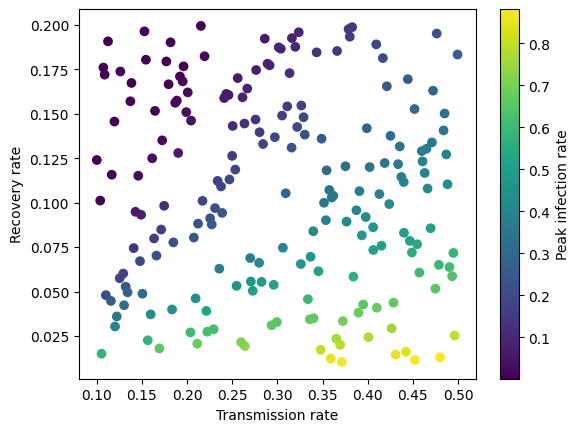

In [3]:
transmission_rate = X[:, 0]
recovery_rate = X[:, 1]

plt.scatter(transmission_rate, recovery_rate, c=y, cmap='viridis')
plt.xlabel('Transmission rate')
plt.ylabel('Recovery rate')
plt.colorbar(label="Peak infection rate")
plt.show

### 2) Emulation
A real world epidemic simulation will be computationally expensive and will take a long time to run. To evaluate the peak infection rate for thousands of different combinations of input parameters, it would be practical to to create a fast emulator model, which can then be used to predict the peak infection rate for new input parameters.

The simplest way to test different emulators is to run `AutoEmulate` with default parameters, providing only inputs `X` and outputs `y`. What happens in the background is that the inputs will be **standardised** (`scale`=True), after which various models are fitted and evaluated using 5-fold **cross-validation**.

In [4]:
em = AutoEmulate()
em.setup(X, y)
best_model = em.compare()

,Values
Simulation input shape (X),"(200, 2)"
Simulation output shape (y),"(200,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Initializing:   0%|          | 0/8 [00:00<?, ?it/s]

### 3) Summarising cross-validation results

We can summarise the cross-validation results to see that several models have a high $R^2$ and root mean squared error, suggesting a good fit. These metrics are the average metric on the test data across cv-folds.

In [5]:
em.summarise_cv()

,model,short,rmse,r2
0,GaussianProcessTorch,gpt,0.003788,0.999702
1,RadialBasisFunctions,rbf,0.003862,0.999433
2,ConditionalNeuralProcess,cnp,0.016250,0.994663
3,SupportVectorMachines,svm,0.023589,0.989631
4,GradientBoosting,gb,0.029979,0.983343
5,RandomForest,rf,0.033720,0.978359
6,SecondOrderPolynomial,sop,0.036846,0.972450
7,LightGBM,lgbm,0.040512,0.969204


We can also look at each of the cv-folds for a specific model, like Gaussian Processes.

In [11]:
em.summarise_cv(model="GaussianProcessTorch")

,fold,rmse,r2
0,0,0.003309,0.999829
1,1,0.006499,0.999241
2,2,0.003200,0.999752
3,3,0.002160,0.999925
4,4,0.003774,0.999763


Next, we can plot the cv results using different plot styles. If the simulation has multiple inputs and outputs, the default is to plot the first input ('input_index=0') and the first output (`output_index=0`), but this can be changed. The default style is `Xy`, which plots predictions and data points.

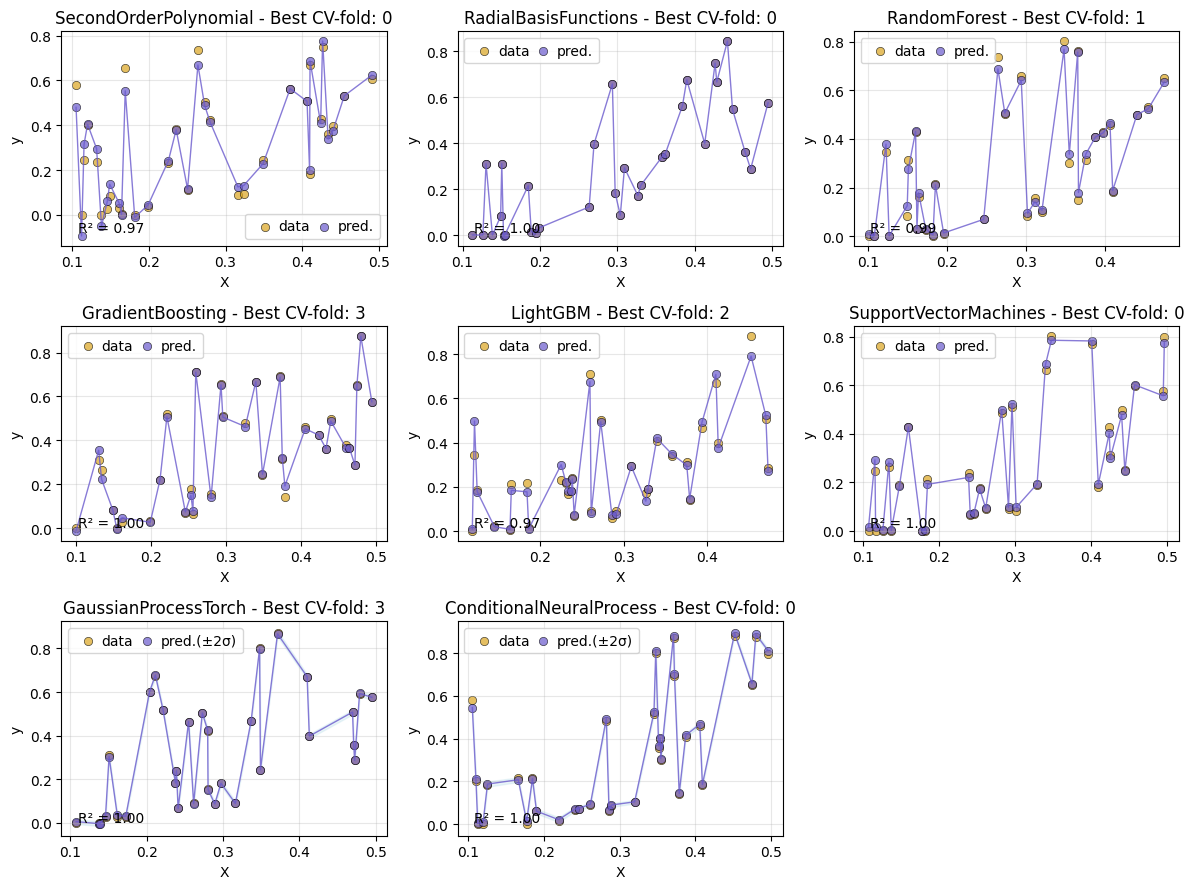

In [13]:
em.plot_cv()

To inspect specific models more closely, we can plot the predictions for each cv fold for a given model.

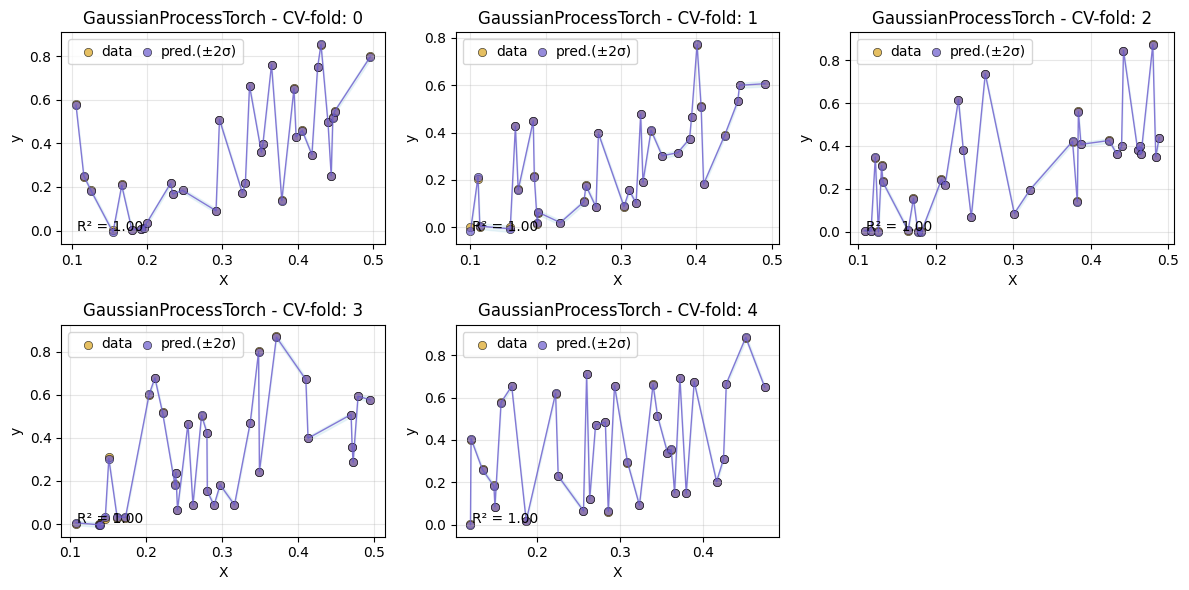

In [14]:
em.plot_cv(model='GaussianProcessTorch')

An alternative plot is `actual_vs_predicted`, which plots the true values against the predicted values.

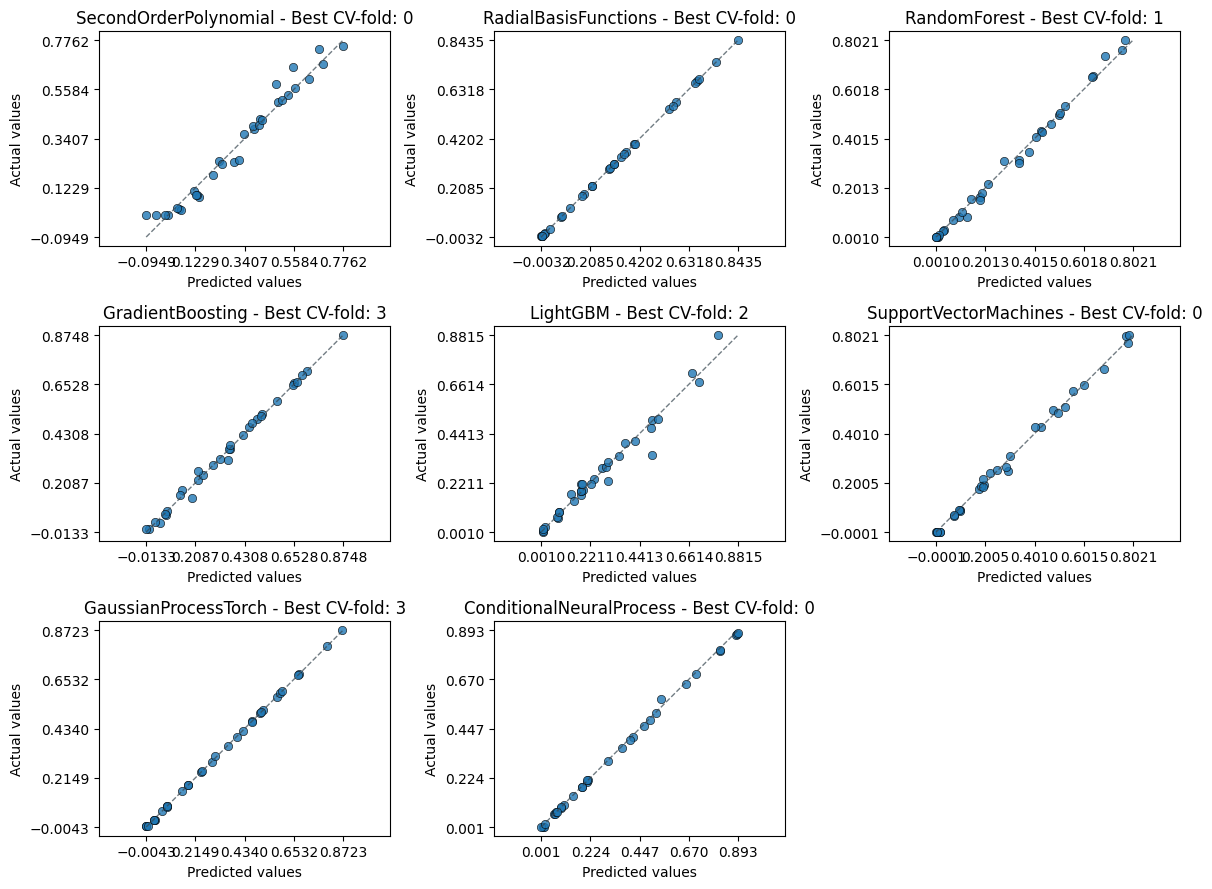

In [18]:
em.plot_cv(style="actual_vs_predicted")

Always good to inspect the residuals too to spot any patterns.

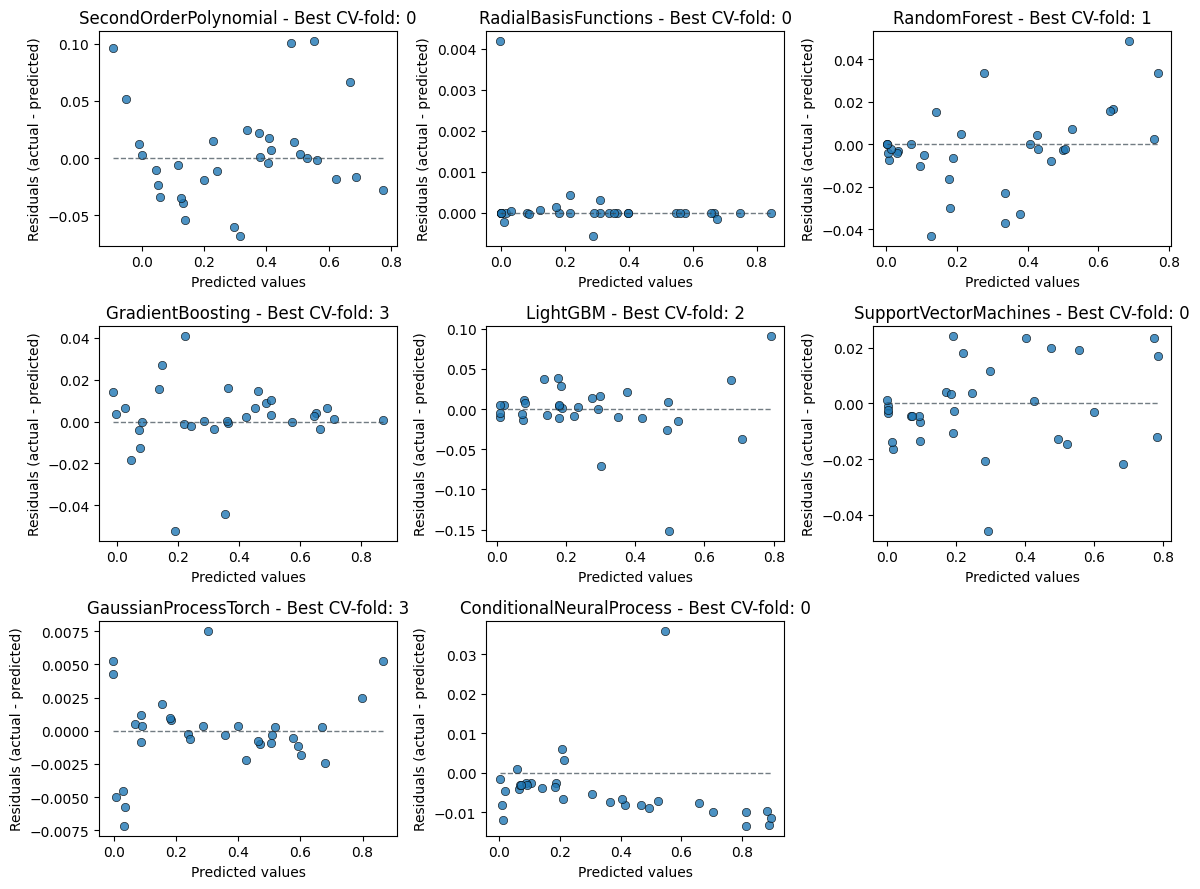

In [20]:
em.plot_cv(style="residual_vs_predicted")

### 5) Evaluate the emulator

After looking at the cv results, we can chose an emulator model and see how it performs on the test-set, which `AutoEmulate` automatically sets aside. 

In [21]:
gp = em.get_model("GaussianProcessTorch")
em.evaluate(gp)

,model,short,target,rmse,r2
0,GaussianProcessTorch,gpt,target_0,0.0025,0.9999


We can plot the test-set performance for chosen emulator.

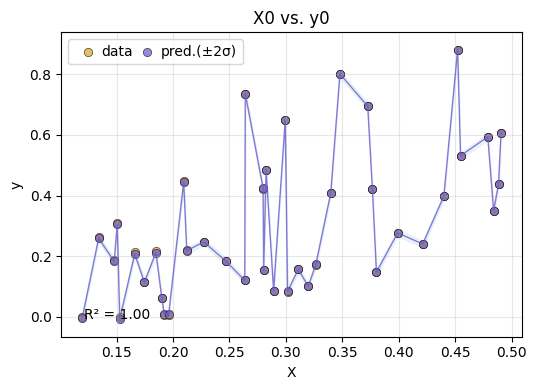

In [24]:
em.plot_eval(gp)

### 4) Refitting the model on the full dataset

`AutoEmulate` splits the dataset into a training and holdout set. All cross-validation, parameter optimisation and model selection is done on the training set. After we selected a best emulator model, we can refit it on the full dataset.

In [33]:
gp_final = em.refit(gp)

Let's now try to predict the peak infection rate for a new set of transmission and recovery rates. Because our emulator is much faster then the original simulation, we can now evaluate the peak infection rate for a much larger set of input parameters.

In [34]:
seed = 42
np.random.seed(seed)

beta = (0.1, 0.5) # lower and upper bounds for the transmission rate
gamma = (0.01, 0.2) # lower and upper bounds for the recovery rate
lhd = LatinHypercube([beta, gamma])
X_new = lhd.sample(1000)
y_new = gp.predict(X_new)

And let's do another plot:

<function matplotlib.pyplot.show(close=None, block=None)>

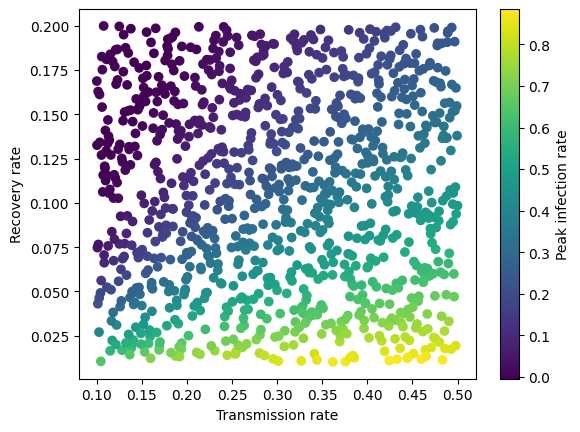

In [35]:
transmission_rate = X_new[:, 0]
recovery_rate = X_new[:, 1]

plt.scatter(transmission_rate, recovery_rate, c=y_new, cmap='viridis')
plt.xlabel('Transmission rate')
plt.ylabel('Recovery rate')
plt.colorbar(label="Peak infection rate")
plt.show

### 4) Saving / Loading



We can save and load the model using `em.save()` and `em.load()`. The model is saved using `joblib.dump`. Next to the model, there is also a `_meta.json` file which specifies the required dependencies and should be present when loading the model to check that the correct package versions are installed.

In [14]:
# em.save(gp_final, "gp_final")
# gp_final_loaded = em.load("gp_final")

## Hyperparameter search

Although we tried to chose default model parameters that work well in a wide range of scenarios, hyperparameter search will often find an emulator model with a better fit. Internally, `AutoEmulate` compares the performance of different models and hyperparameters using cross-validation on the training data, which can be computationally expensive and time-consuming for larger datasets. To speed it up, we can parallelise the process with `n_jobs`.

For each model, we've pre-defined a search space for hyperparameters. When setting up `AutoEmulate` with `param_search=True`, we default to using random search with `param_search_iters = 20` iterations. The alternative is `param_search_method = "bayes"` which uses a Bayesian optimisation method (see [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) for details). 

Let's do a hyperparameter search for the Gaussian Process and Random Forest models.

In [36]:
em = AutoEmulate()
em.setup(X, y, param_search=True, param_search_type="random", param_search_iters=20, models=["GaussianProcessTorch", "RandomForest"], n_jobs=-2) # n_jobs=-2 uses all cores but one
em.compare()

,Values
Simulation input shape (X),"(200, 2)"
Simulation output shape (y),"(200,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),True
Type of hyperparameter search (search_type),random
Number of sampled parameter settings (param_search_iters),20
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold


Initializing:   0%|          | 0/2 [00:00<?, ?it/s]

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GaussianProcessTorch(covar_module=RQKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_alpha_constraint): Positive()
),
                                      lr=0.05, max_epochs=200,
                                      mean_module=ConstantMean(),
                                      optimizer=<class 'torch.optim.adam.Adam'>))])

In [37]:
em.summarise_cv()

,model,short,rmse,r2
0,GaussianProcessTorch,gpt,0.003518,0.999664
1,RandomForest,rf,0.040487,0.968151


**Notes**: 
* Some models, such as `GaussianProcessTorch` can be slow to run hyperparameter search on larger datasets (say n > 2000). 
* Use the `models` argument to only run hyperparameter search on a subset of models to speed up the process.
* When possible, use `n_jobs` to parallelise the hyperparameter search. With larger datasets, we recommend setting `param_search_iters` to a lower number, such as 5, to see how long it takes to run and then increase it if necessary.
* all models can be specified with short names too, such as `rf` for `RandomForest`, `gpt` for `GaussianProcessTorch`, `svm` for `SupportVectorMachines`, etc

## Multioutput simulations

All models run with multi-output data as well. Some models naively support multiple outputs. For models that don't, `AutoEmulate` fits the model to each output separately under the hood. To see which models run separately for each output, we can check a model and see whether the pipeline includes a `MultiOutputRegressor` step. Note: all following metrics are averaged across outputs.

In [38]:
from autoemulate.simulations.projectile import simulate_projectile_multioutput
lhd = LatinHypercube([(-5., 1.), (0., 1000.)]) # (upper, lower) bounds for each parameter
X = lhd.sample(100)
y = np.array([simulate_projectile_multioutput(x) for x in X])
X.shape, y.shape

((100, 2), (100, 2))

In [39]:
em = AutoEmulate()
em.setup(X, y)

,Values
Simulation input shape (X),"(100, 2)"
Simulation output shape (y),"(100, 2)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


If we print a model, say SVM, we can see that it's wrapped in a `MultiOutputRegressor`, because it doesn't natively support multioutput data.

In [40]:
print(em.models[5]) # print the 5th model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MultiOutputRegressor(estimator=SupportVectorMachines()))])


## Custom standardisation, cross-validation and dimension reduction

### Standardisation
`AutoEmulate` standardises inputs by default (`scale=True`) to have zero mean and unit variance. It uses `scaler=StandardScaler()` but [other normalisers](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) can be used, or the inputs can be left unscaled (`scale=False`). In addition, some models, like Gaussian Processes also standardise outputs, which makes them work better. Checking the parameters of a model with `model.get_params()` will show whether the model standardises outputs.

### Dimension reduction
When there are lots of input variables, it can be useful to reduce the dimensionality. To do this, we can add a dimension reduction step to each model using `reduce_dim=True`. Be default, this uses PCA from scikit-learn, but [other dimension reduction methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) can be used.

### Cross-validation

The default cross-validation method is 5-fold cross-validation using `sklearn.model_selection.KFold`. The parameters can be changed or other cross-validation methods can be used, see [sklearn.model_selection splitter classes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for details.

### Example

Let's say we wanted to change to a MinMaxScaler, to do PCA but retain components explaining more than 99%  of the variance and do KFold cross validation but with 3 splits and no shuffling. To do this, we can just import the respective classes from sklearn and pass them to `setup()`.

In [41]:
### Example
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

mmscaler = MinMaxScaler()
pca = PCA(0.99)
kfold = KFold(n_splits=3, shuffle=False)

em = AutoEmulate()
em.setup(X, y, scale=True, scaler=mmscaler, cross_validator=kfold)
best_model = em.compare()


,Values
Simulation input shape (X),"(100, 2)"
Simulation output shape (y),"(100, 2)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),MinMaxScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Initializing:   0%|          | 0/8 [00:00<?, ?it/s]

**Note**: Not all possible cross validators, scalers and decomposers have been tested and only a few make sense in the current version of `AutoEmulate`. If you encounter any issues, please open an [issue on GitHub](https://github.com/alan-turing-institute/autoemulate/issues/new/choose).